In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt

データ読み込み

In [9]:
import pandas as pd
from pycaret.datasets import get_data
data = get_data('./data/processed_pycaret_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').sum()
data = data.asfreq('D')
data.head()

ValueError: Data could not be read. Please check your inputs...

In [3]:
import pandas as pd
data = pd.read_csv('./data/processed_pycaret_data.csv', index_col=['datetime'], parse_dates=['datetime'])
data = data.drop("PM10", axis=1)
data.head()

,PM25,SO2,NO2,CO,O3,temp,pres,dewp,prec,wind_dire,wd
datetime,,,,,,,,,,,
2013-03-01 00:00:00,3.0,3.0,8.0,300.0,44.0,-0.9,1025.8,-20.5,0.0,7,9.3
2013-03-01 01:00:00,12.0,3.0,7.0,300.0,47.0,-1.1,1026.1,-21.3,0.0,7,9.4
2013-03-01 02:00:00,14.0,NaN,7.0,200.0,22.0,-1.7,1026.2,-23.0,0.0,7,8.6
2013-03-01 03:00:00,12.0,3.0,5.0,NaN,NaN,-2.1,1027.3,-23.3,0.0,7,6.6
2013-03-01 04:00:00,12.0,3.0,NaN,200.0,11.0,-2.4,1027.7,-22.9,0.0,7,4.5


In [5]:
def preprocessing(train):
    # 離散値
    train['wind_dire'] = train['wind_dire'].fillna(method='ffill')  # 欠損値

    le = LabelEncoder() # ラベルエンコーダー
    train['wind_dire'] = le.fit_transform(train['wind_dire'])
    
    # 連続値
    tmp = train.drop('wind_dire', axis=1).interpolate().copy()  # 欠損値
    tmp['wind_dire'] = train['wind_dire']
    train = tmp.copy()
    train.dropna(how='any', inplace=True)   # temp_diffが必ず欠損値残るため除去
    
    return train

In [6]:
train_data = preprocessing(data)

In [8]:
train_data.isnull().sum()

PM25         0
SO2          0
NO2          0
CO           0
O3           0
temp         0
pres         0
dewp         0
prec         0
wd           0
wind_dire    0
dtype: int64

<AxesSubplot:xlabel='datetime'>

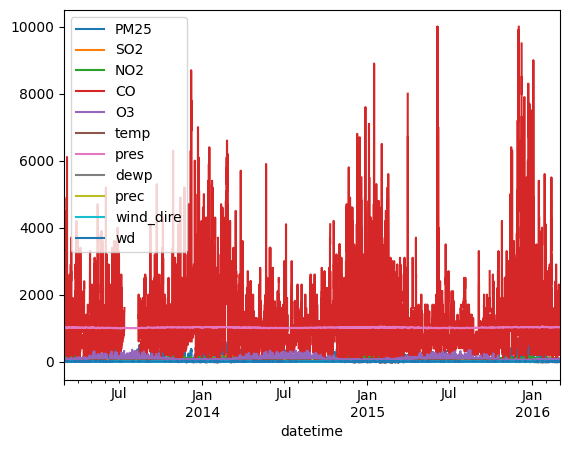

In [10]:
# plot the data
train_data.plot()

セットアップ初期化

In [14]:
# with functional API
from pycaret.time_series import *
#fh:予測対象期間
#fold:交差検証の回数
#seasonal_period:周期
setup(train_data,target = 'PM25',use_gpu = True, fh = 365 , fold = 1, session_id = 123)
# with new object-oriented API
""" from pycaret.internal.pycaret_experiment import TimeSeriesExperiment """
from pycaret.time_series import TSForecastingExperiment
exp = TSForecastingExperiment()
exp.setup(train_data,target = 'PM25',use_gpu = True, fh = 365 , fold = 1, session_id = 123)

,Description,Value
0,session_id,123
1,Target,PM25
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(26304, 11)"
5,Transformed data shape,"(26304, 11)"
6,Transformed train set shape,"(25939, 11)"
7,Transformed test set shape,"(365, 11)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Description,Value
0,session_id,123
1,Target,PM25
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(26304, 11)"
5,Transformed data shape,"(26304, 11)"
6,Transformed train set shape,"(25939, 11)"
7,Transformed test set shape,"(365, 11)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [9]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,26304.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,79.944845
3,Summary,Statistics,Transformed,Median,,55.0
4,Summary,Statistics,Transformed,Standard Deviation,,80.903367
5,Summary,Statistics,Transformed,Variance,,6545.354814
6,Summary,Statistics,Transformed,Kurtosis,,6.111652
7,Summary,Statistics,Transformed,Skewness,,1.99892
8,Summary,Statistics,Transformed,# Distinct Values,,976.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",246835.186051


In [ ]:
exp.plot_model()

In [ ]:
# functional API
plot_model(plot = 'ts')
# object-oriented API
exp.plot_model(plot = 'ts')

In [ ]:
# cross-validation plot
plot_model(plot = 'cv')

In [ ]:
# ACF plot
plot_model(plot = 'acf')

In [ ]:
# Diagnostics plot
plot_model(plot = 'diagnostics')

In [ ]:
# Decomposition plot
plot_model(plot = 'decomp_stl')

In [ ]:
# functional API
best = compare_models(exclude = 'knn_cds_dt')
# object-oriented API
best = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6496,1.0242,38.6992,90.7723,1.6105,0.6958,0.3227,42.2700
arima,ARIMA,0.7298,0.9496,43.4786,84.1670,2.4520,0.7896,0.4177,311.2400
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.7389,1.0835,44.0196,96.0360,1.6248,0.7723,0.2419,147.7800
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8049,1.0420,47.9539,92.3522,2.1744,0.8877,0.2990,54.4500
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8050,1.0433,47.9599,92.4716,2.3114,0.8867,0.2971,31.1500
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8315,1.0349,49.5364,91.7229,2.4498,0.9169,0.3085,52.7500
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8353,1.0453,49.7650,92.6427,2.9787,0.8895,0.2945,33.2500
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8604,1.0318,51.2583,91.4527,2.9477,0.9170,0.3125,31.2200
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8612,1.0337,51.3045,91.6179,2.8139,0.9266,0.3101,31.6200
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.8643,1.0338,51.4889,91.6294,2.8750,0.9286,0.3099,31.9500


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.6009,1.0218,35.7977,90.5616,1.1997,0.6093,0.3259,79.6400
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.6496,1.0242,38.6992,90.7723,1.6105,0.6958,0.3227,39.7500
arima,ARIMA,0.7298,0.9496,43.4786,84.1670,2.4520,0.7896,0.4177,361.5800
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.7389,1.0835,44.0196,96.0360,1.6248,0.7723,0.2419,157.0700
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.8049,1.0420,47.9539,92.3522,2.1744,0.8877,0.2990,60.4100
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.8050,1.0433,47.9599,92.4716,2.3114,0.8867,0.2971,38.0900
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.8315,1.0349,49.5364,91.7229,2.4498,0.9169,0.3085,57.7200
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.8353,1.0453,49.7650,92.6427,2.9787,0.8895,0.2945,40.7600
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.8604,1.0318,51.2583,91.4527,2.9477,0.9170,0.3125,38.7000
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.8612,1.0337,51.3045,91.6179,2.8139,0.9266,0.3101,36.8700


In [ ]:
# create fbprophet model
prophet = create_model('prophet')
print(prophet)

ValueError: Estimator prophet not available. Please see docstring for list of available estimators.

In [ ]:
tuned_prophet = tune_model(prophet)
print(tuned_prophet)


In [ ]:
plot_model(best, plot = 'forecast')

In [ ]:
# forecast in unknown future
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 30})

In [ ]:
# in-sample plot
plot_model(best, plot = 'insample')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [ ]:
# residuals plot
plot_model(best, plot = 'residuals')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [ ]:
# diagnostics plot
plot_model(best, plot = 'diagnostics')

In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.
In sample predictions has not been implemented for this estimator of type 'BaseCdsDtForecaster' in `sktime`. When this is implemented, it will be enabled by default in pycaret.


In [ ]:
# finalize model
final_best = finalize_model(best)
# generate predictions
predict_model(final_best, fh = 90)

In [ ]:
# save the model
save_model(final_best, 'my_best_model')